In [446]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import os
import re
import cv2
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [410]:
results_dir = '../darknet/parse/parsed'
data_dir = '../orig_data'
results = [name for name in os.listdir(results_dir) if os.path.isfile(os.path.join(results_dir, name))]

In [92]:
def scale_box(df, im):
    predict_im_size = 832.
    df.columns = ['prob', 'x', 'y', 'w', 'h']

    # Vertical is stretched as the same as width, rest is filled with blank space
    im_height, im_width, _ = im.shape
    width_scale = im_width / predict_im_size
    height_scale = im_height / predict_im_size
    scale_diff = (predict_im_size - (im_height / width_scale)) / 2.
    
    df.iloc[:,[1,3]] = np.round(df.iloc[:,[1,3]] * width_scale)
    df.iloc[:,[2,4]] = np.round((df.iloc[:,[2,4]] - scale_diff) * width_scale)
    df.iloc[:,3] = df.iloc[:,3] - df.iloc[:,1]
    df.iloc[:,4] = df.iloc[:,4] - df.iloc[:,2]
    
    return df

In [4]:
def show_image(im):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.] )
    ax.set_axis_off( )
    fig.add_axes(ax)
    
    ax.imshow(im)
    return ax

In [134]:
def xywh_2_ltbr(df):
    df = df.copy(deep=True)
    df.columns = ['prob', 'x1', 'y1', 'x2', 'y2']
    df.iloc[:,3] = df.iloc[:,3] + df.iloc[:,1]
    df.iloc[:,4] = df.iloc[:,4] + df.iloc[:,2]
    
    return df

def ltbr_2_xywh(df):
    df = df.copy(deep=True)
    df.columns = ['prob', 'x', 'y', 'w', 'h']
    df.iloc[:,3] = df.iloc[:,3] - df.iloc[:,1]
    df.iloc[:,4] = df.iloc[:,4] - df.iloc[:,2]
    
    return df

In [347]:
def is_intersecting(df):
    df = xywh_2_ltbr(df)
    result_array = []
    for index, data in df.iterrows():
        result = np.array(np.logical_not((df.x1 > data.x2) |
                                         (df.x2 < data.x1) | 
                                         (df.y1 > data.y2) | 
                                         (df.y2 < data.y1)))
        result_array = np.append(result_array, result)
    result_array = result_array.reshape((df.shape[0], df.shape[0]))
    np.fill_diagonal(result_array, 0)
    return result_array

def pick_max(df, value):
    df = df.copy(deep = True)
    return df.map(lambda x: x if x >= value else value)

def pick_min(df, value):
    df = df.copy(deep = True)
    return df.map(lambda x: x if x <= value else value)

def box_and_overlap_area(df, conversion = False):
    if conversion is True:
        df_ltbr = xywh_2_ltbr(df)
    else:
        df_ltbr = df.copy(deep = True)
        df_ltbr.columns = ['prob', 'x1', 'y1', 'x2', 'y2']
    
    result_array = []
    for index, data in df_ltbr.iterrows():
        left = pick_max(df_ltbr['x1'], data.x1)
        right = pick_min(df_ltbr['x2'], data.x2)
        top = pick_max(df_ltbr['y1'], data.y1)
        bot = pick_min(df_ltbr['y2'], data.y2)
        
        height = pick_max((bot - top), 0)
        width = pick_max((right - left), 0)
        
        result_array = np.append(result_array, height * width)
    result_array = result_array.reshape((df.shape[0], df.shape[0]))
    
    return result_array

def separate_box_and_overlap(combined):
    box_area = np.diagonal(combined).copy()
    np.fill_diagonal(combined, 0)
    
    return box_area, combined

def overlap_area(df):
    overlap_area = box_and_overlap_area(df)
    np.fill_diagonal(overlap_area, 0)
    return overlap_area

def box_area(df):
    box_area = box_and_overlap_area(df)
    return np.diagonal(box_area)

def overlap_percentage(df):
    combined = box_and_overlap_area(df)
    box_area, overlap_area = separate_box_and_overlap(combined)

    iu1 = np.triu_indices(overlap_area.shape[0])
    overlap_area[iu1] = 0
    overlap_coordinates = np.nonzero(overlap_area)
    
    box1, box2 = overlap_coordinates
    
    result_array = []
    for i in xrange(box1.shape[0]):
        specific_overlap_area = overlap_area[box1[i], box2[i]]
        total_area = box_area[box1[i]] + box_area[box2[i]] - specific_overlap_area
        percentage = specific_overlap_area / total_area
        result_array.append(percentage)
    
    return result_array    

In [348]:
result_array = []
counter = 0
for result in results:
    csv_path = os.path.join(results_dir, result)
    csv_file = pd.read_csv(csv_path, header = None)
    
    result = overlap_percentage(csv_file)
    result_array = np.append(result_array, result)
    counter = counter + 1
print counter

9787


In [349]:
df = pd.DataFrame(result_array)

                  0
count  51851.000000
mean       0.126082
std        0.101687
min        0.000031
25%        0.042930
50%        0.099654
75%        0.186071
max        0.421559


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f06db98b1d0>]], dtype=object)

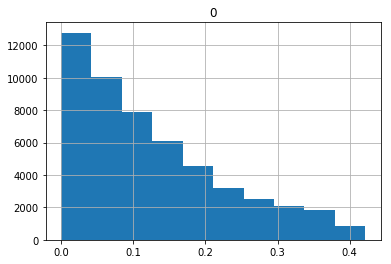

In [353]:
print df.describe()
df.hist()

In [418]:
def get_video_info(path):
    video_id = re.search('.*(?=(_clip))', path).group(0).split('/')[-1]
    clip_id = re.search('clip_[0-9]{2}', path).group(0)
    frame_number = path[-6:-4]
    
    return video_id, clip_id, frame_number
    
def produce_image(result_csv_path, bounding_box = True, truth = False):
    global data_dir
    
    video_id, clip_id, frame_number = get_video_info(result_csv_path)
    
    image_path = os.path.join(data_dir, video_id, clip_id, frame_number + '.png')
    im = mpimg.imread(image_path)
    
    ax = show_image(im)

    if bounding_box == True:
        csv_file = pd.read_csv(result_csv_path, header = None)
        fixed_pd = scale_box(csv_file, im)
        counter = 0
        for _, bbox in fixed_pd.iterrows():
            counter = counter + 1
            rect = patches.Rectangle((bbox.x, bbox.y), bbox.w, bbox.h, linewidth = 3, fill = False)
            ax.add_patch(rect)
        
    if truth is True:
        bbox_data_path = os.path.join(data_dir, video_id, clip_id, frame_number + '_info.csv')
        bbox_data = pd.read_csv(bbox_data_path)
        
        for _, bbox in bbox_data.iterrows():
            rect = patches.Rectangle((bbox.x, bbox.y), bbox.w, bbox.h, linewidth = 3, fill = False, color = 'yellow')
            ax.add_patch(rect)
        

../darknet/parse/parsed/2H45XQEjFQ8_clip_12_05.txt
[0.0082246504523557744, 0.17194875252865813, 0.024850042844901457, 0.0063114800705066244, 0.082167594730408799, 0.021649484536082474, 0.1465603190428714]


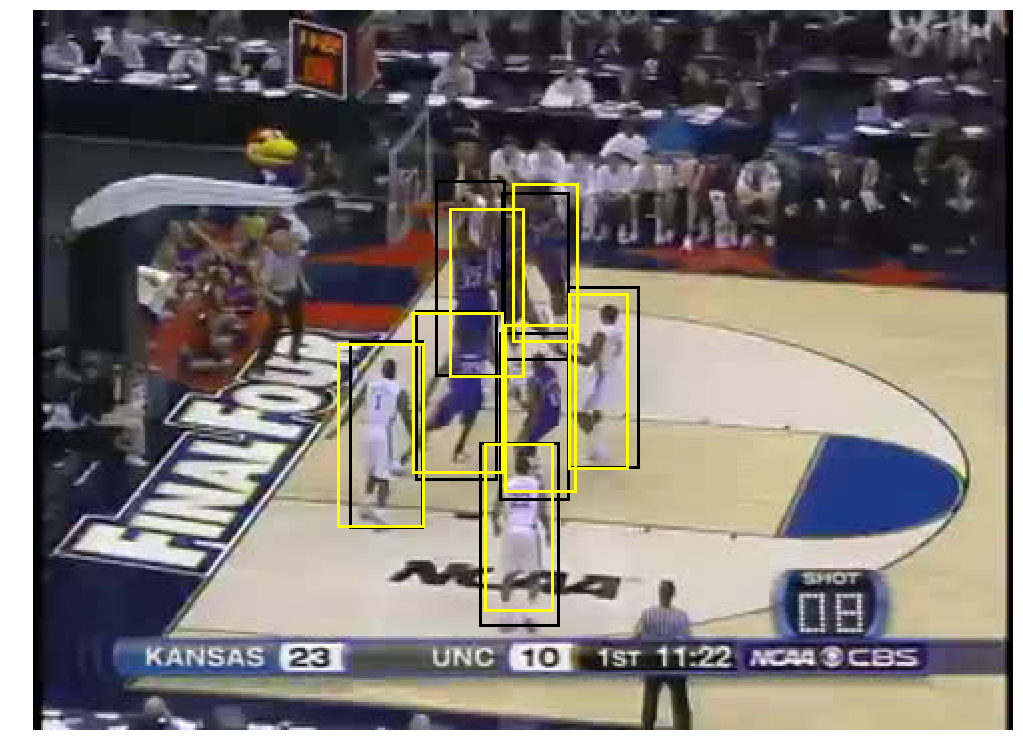

In [419]:
skip_counter = 0
for result in results:
    skip_counter = skip_counter + 1
    if skip_counter < 30:
        continue
    csv_path = os.path.join(results_dir, result)
    print csv_path
    csv_file = pd.read_csv(csv_path, header = None)

    print overlap_percentage(csv_file)
    produce_image(csv_path, bounding_box = True ,truth = True)
    break # REMOVE

../darknet/parse/parsed/2H45XQEjFQ8_clip_12_01.txt
[0.017177589852008457, 0.037156231714452898, 0.073518707235405448, 0.022140619937358247, 0.042969682501790403, 0.0054714340246850741, 0.0018867924528301887, 0.060567823343848581]
../darknet/parse/parsed/2H45XQEjFQ8_clip_12_02.txt
[0.12254371035123007, 0.028330185534940561, 0.11421679909194098, 0.066934404283801874, 0.021901443504230962, 0.087511944877533568]
../darknet/parse/parsed/2H45XQEjFQ8_clip_12_03.txt
[0.099961846623426179, 0.028895448190150691, 0.052780638516992794, 0.095596681557115509, 0.059059309826517192, 0.043353181240382684, 0.10966322558808597]
../darknet/parse/parsed/2H45XQEjFQ8_clip_12_04.txt
[0.04159147546618544, 0.045436428856117976, 0.051512673753066229, 0.089373260898370208, 0.031147402980048824, 0.036300080666845924, 0.0077672645106623356, 0.00055466193355150034, 0.11050520245706406]
../darknet/parse/parsed/2H45XQEjFQ8_clip_12_05.txt
[0.0082246504523557744, 0.17194875252865813, 0.024850042844901457, 0.006311480070

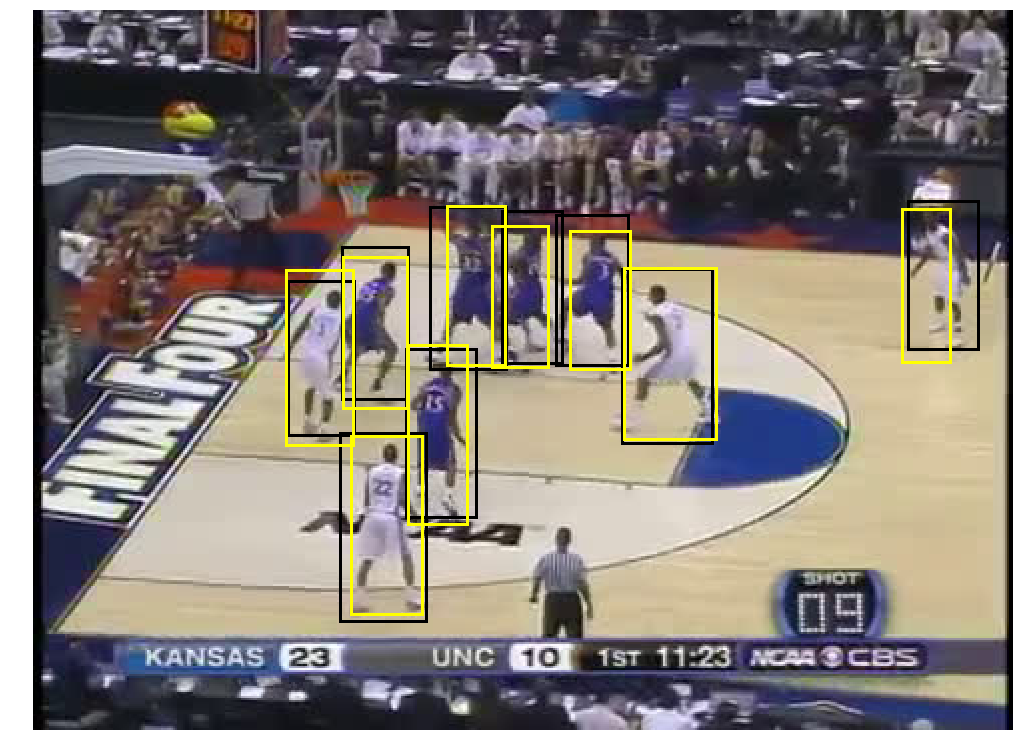

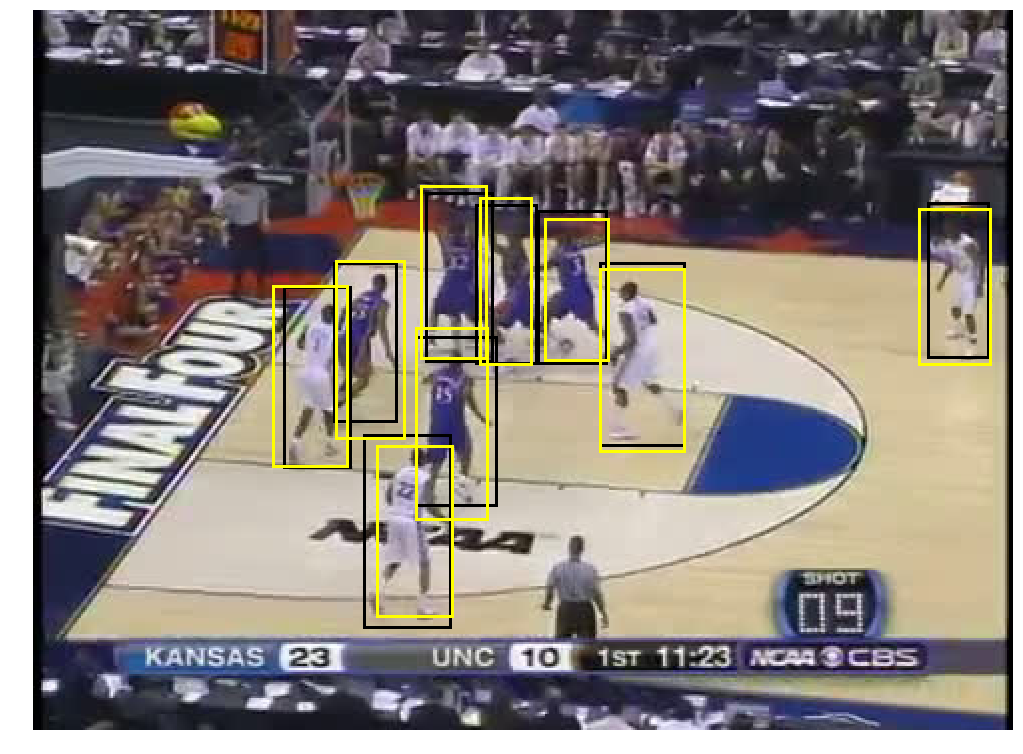

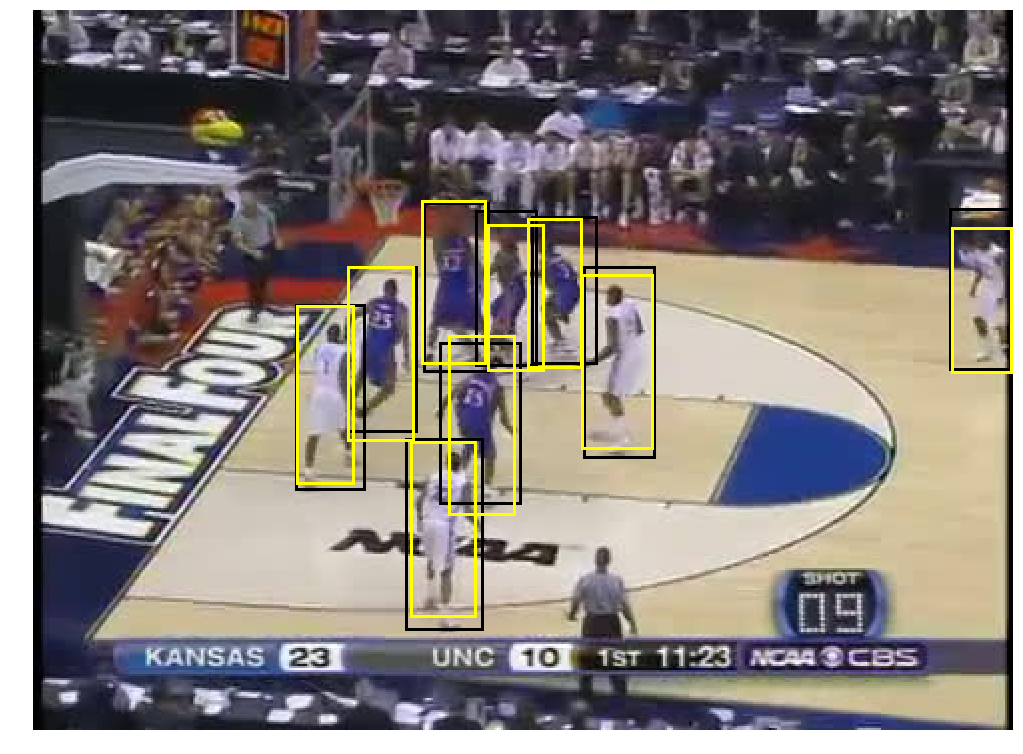

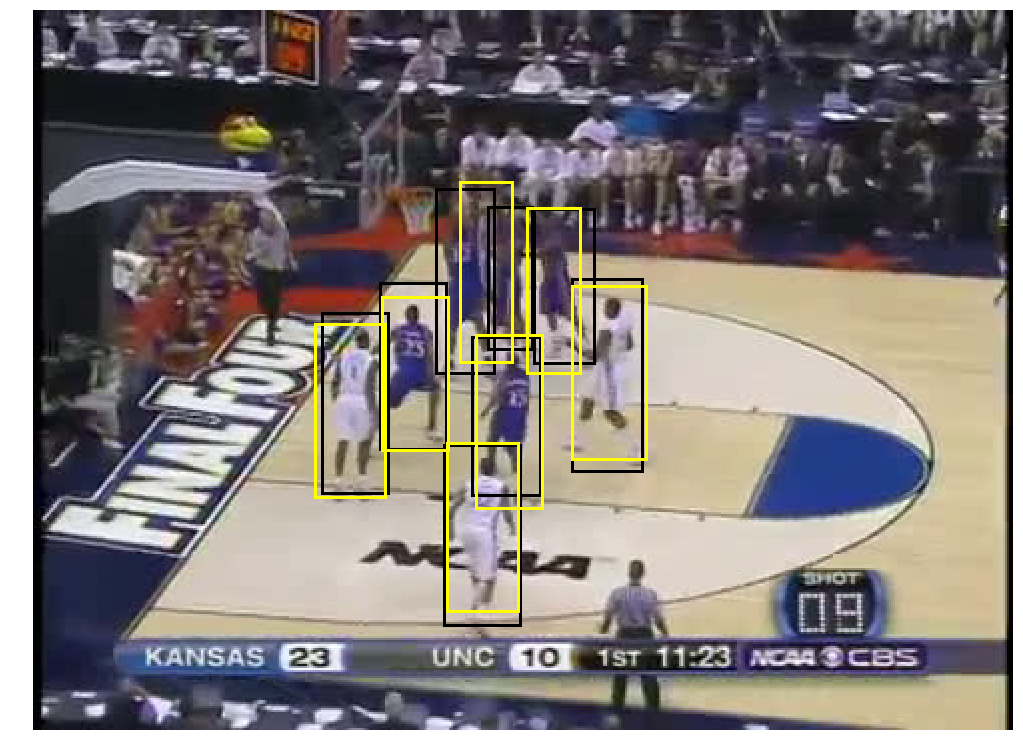

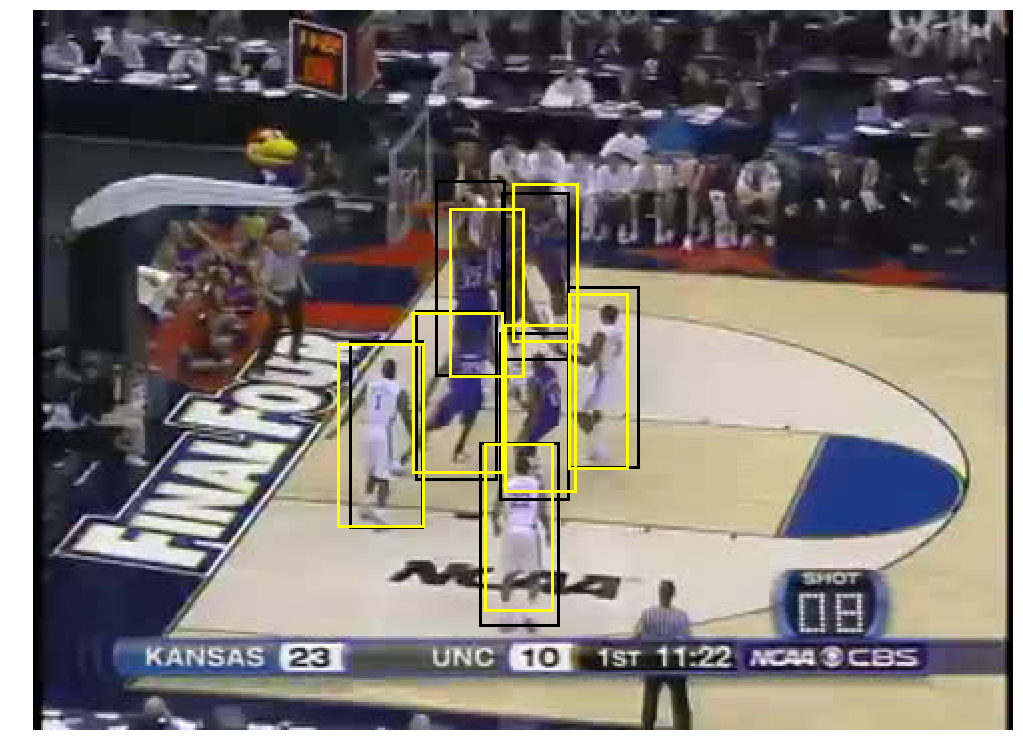

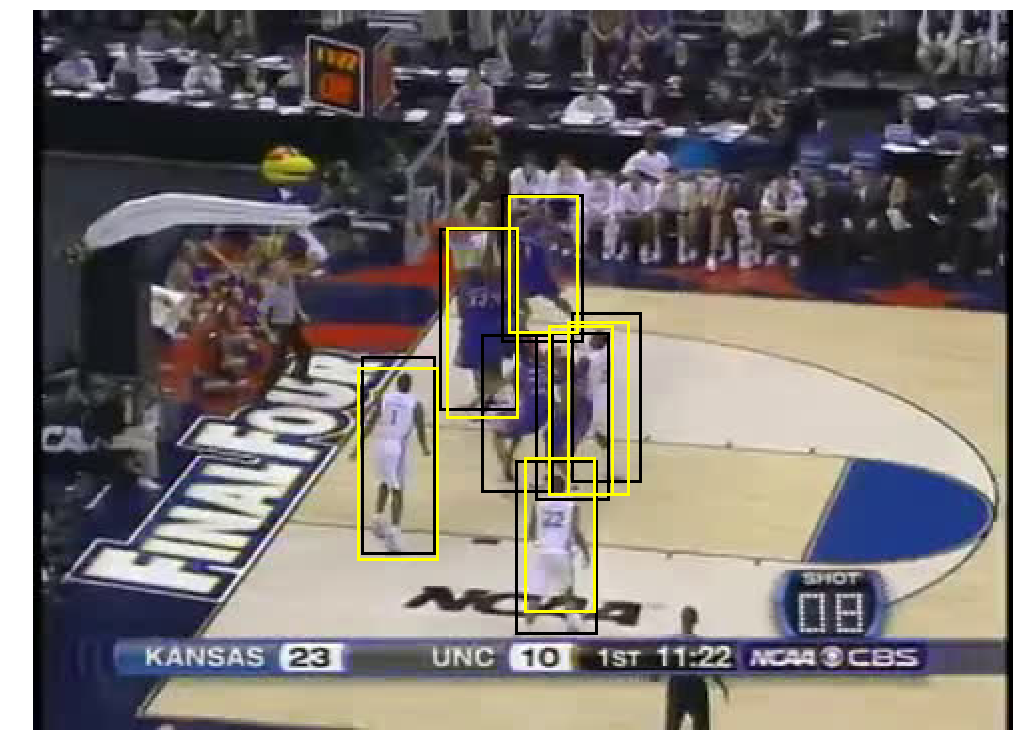

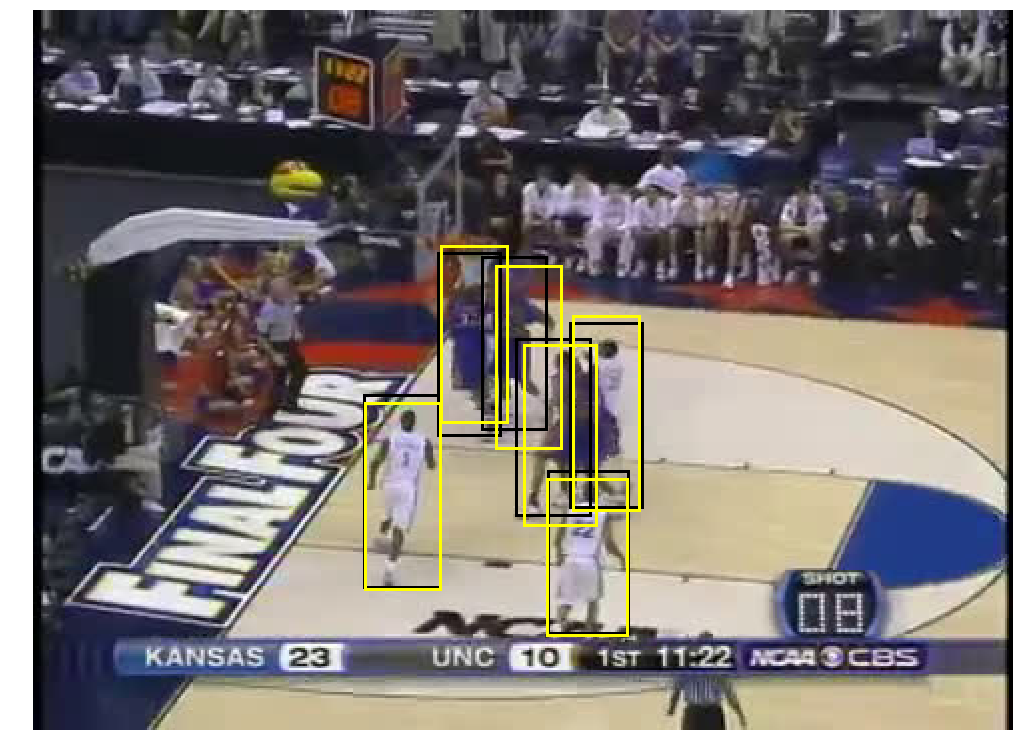

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


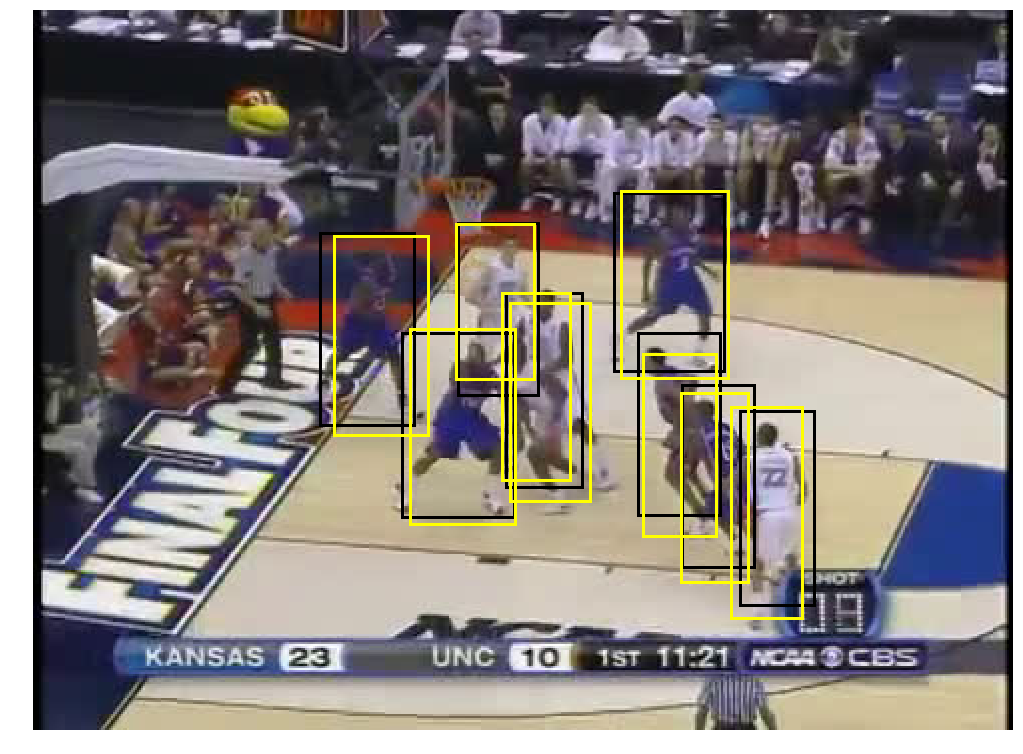

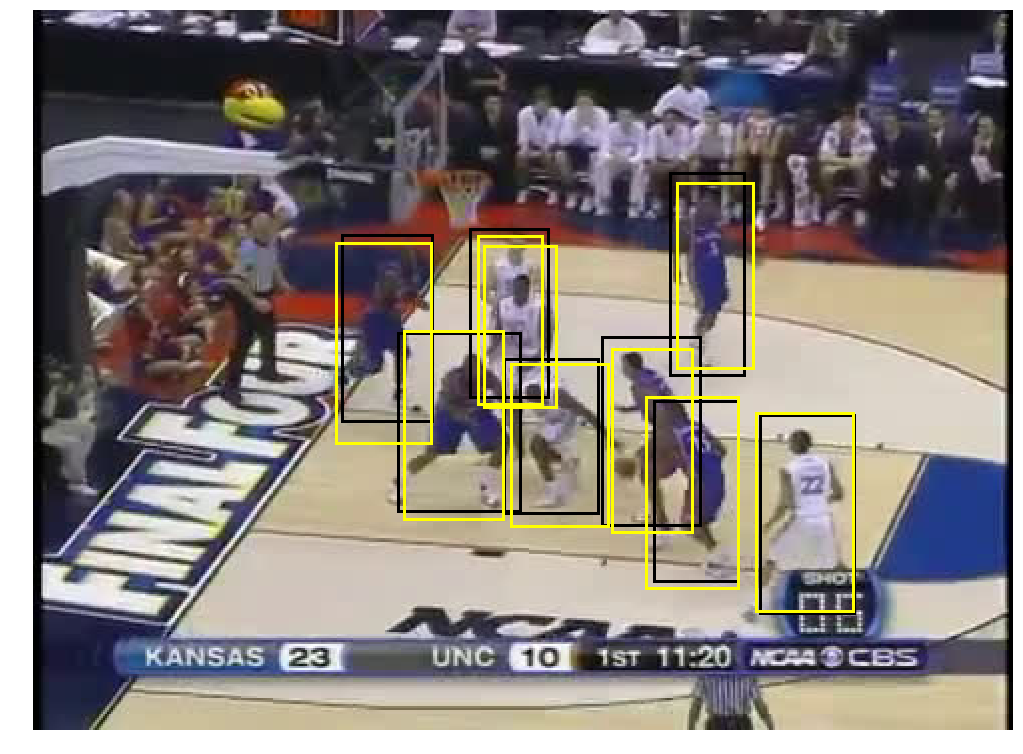

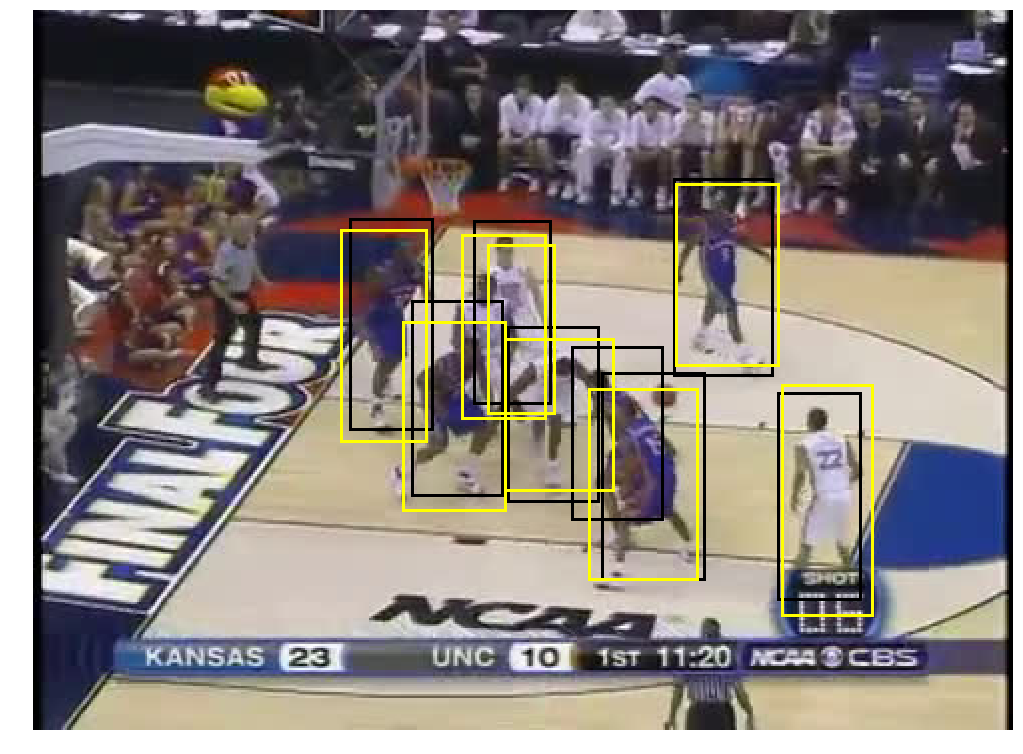

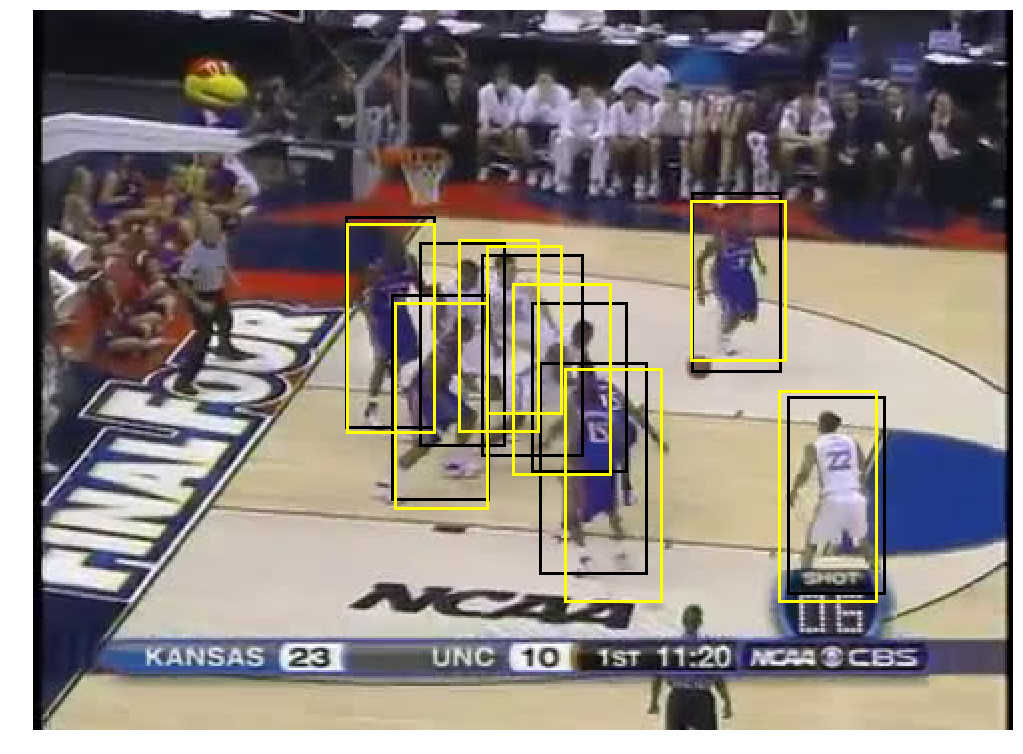

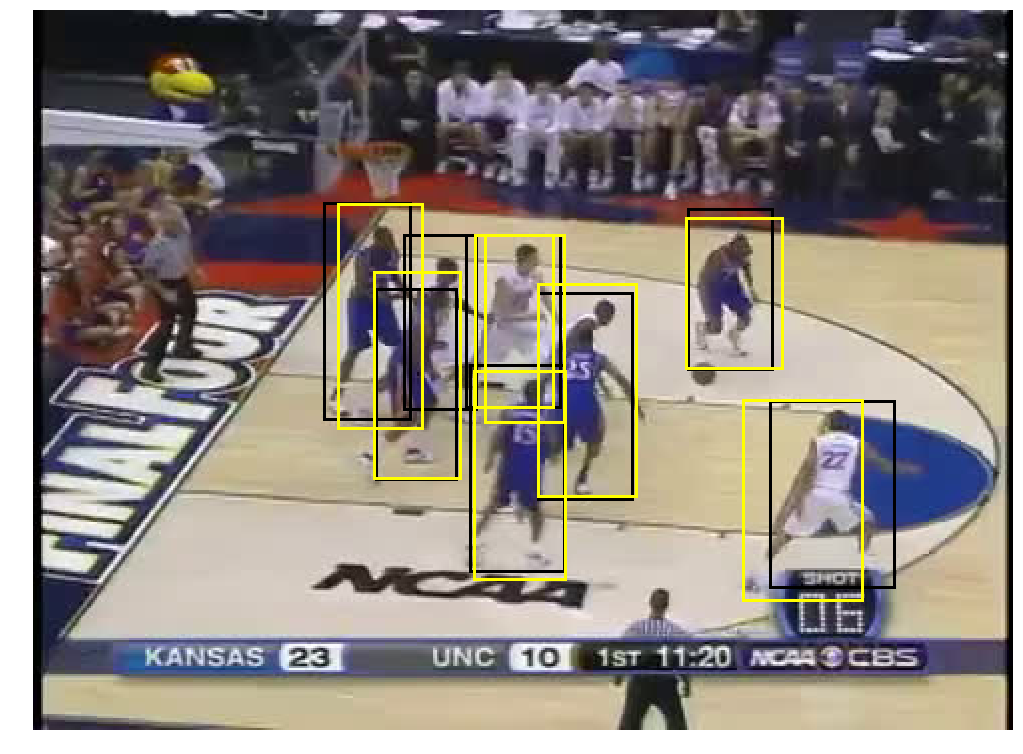

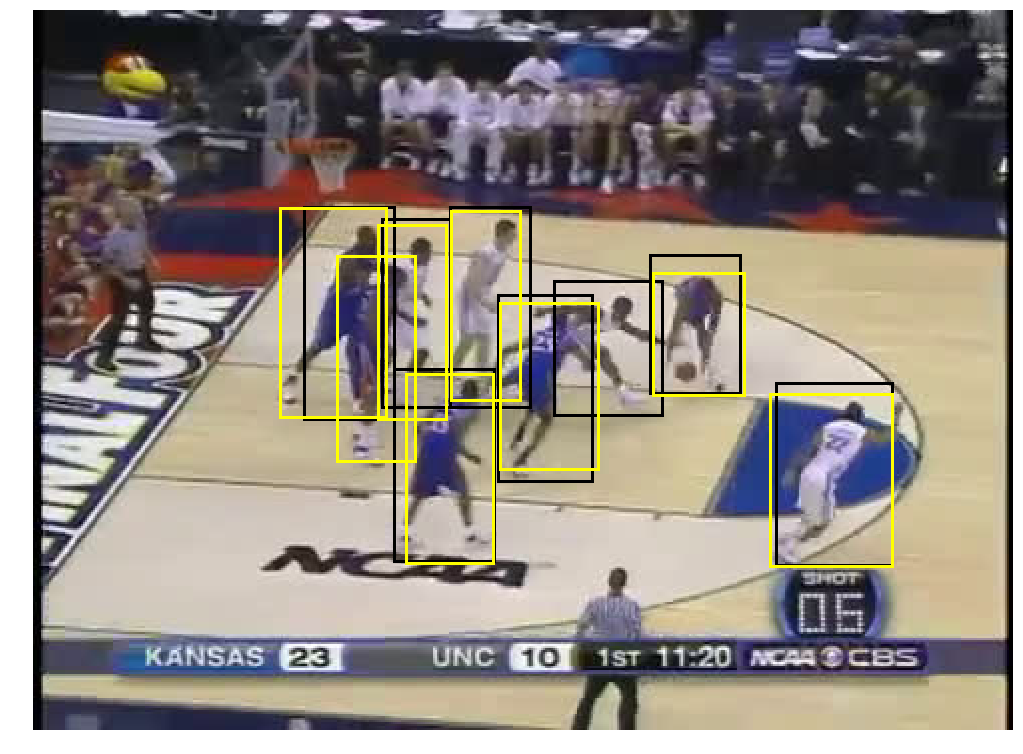

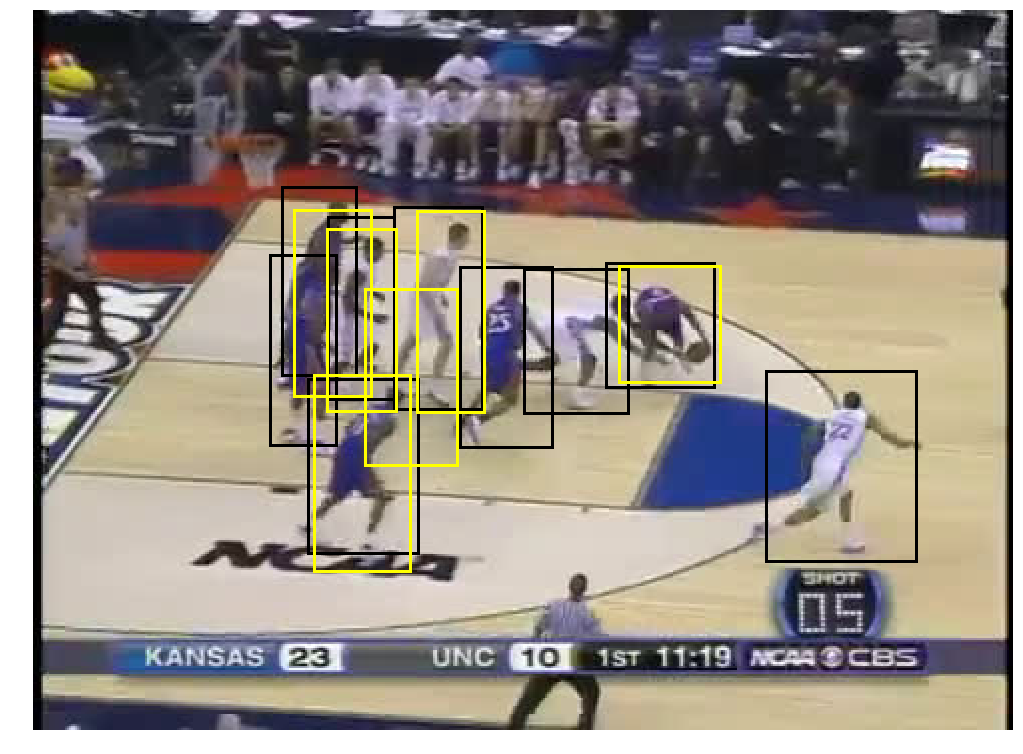

In [448]:
video_id = '2H45XQEjFQ8'
clip_id  = 'clip_12'
image_dir = os.path.join(data_dir, video_id, clip_id)
results = [name for name in os.listdir(image_dir) if 'png' in name]
results.sort()

skip_counter = 0
for result in results:
    result = result.split('.')[0]
    skip_counter = skip_counter + 1

    csv_name = video_id + '_' + clip_id + '_' + result + '.txt'
    csv_path = os.path.join(results_dir, csv_name)
    print csv_path
    csv_file = pd.read_csv(csv_path, header = None)

    print overlap_percentage(csv_file)
    produce_image(csv_path, bounding_box = True ,truth = True)
    
plt.show()

In [432]:
print results

['15.png', '12.png', '20.png', '03.png', '04.png', '13.png', '14.png', '05.png', '02.png', '01.png', '06.png', '08.png', '19.png', '17.png', '10.png', '09.png', '07.png', '11.png', '16.png', '18.png']
